In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

%matplotlib inline

# Dataset Handler

In [2]:
class Dataset_Handler():
    def __init__(self, sequence,  progress_bar=True, low_memory=True):
        
        
        
        # This will tell odometry functin how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        self.seq_dir = ''
        
        # Get names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.left_image_files.sort(key=lambda f: int(re.sub('\D', '', f)))
        self.right_image_files.sort(key=lambda f: int(re.sub('\D', '', f)))
        self.num_frames = len(self.left_image_files)
        
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        #zed için farklı bir transformation matrixle çarpmak gerekiyor öncesinde
        P1_pre = np.array(calib.loc['P1:']).reshape((3,4))
        k = P1_pre[:,:-1]
        zort = np.eye(3)
        t = np.array([-0.012, 0, 0]).reshape(3,1)
        transformation = np.hstack((zort, t))
        self.P1 = k @ transformation

        # Get images and lidar loaded
        if self.low_memory:
            # Will use generators to provide data sequentially to save RAM
            # Use class method to set up generators
            self.reset_frames()
            # Store original frame to memory for testing functions
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
            
        else:
            # If RAM is not a concern (>32GB), pass low_memory=False
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                if progress_bar:
                    bar.update(i+1)
                
            self.imheight = self.images_left[0].shape[0]
            self.imwidth = self.images_left[0].shape[1]
            # Keep consistent instance variable names as when using low_memory
            self.first_image_left = self.images_left[0]
            self.first_image_right = self.images_right[0]
            self.second_image_left = self.images_left[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        
        pass


In [3]:
handler = Dataset_Handler('YARRAK')

**Disparity calculator**

In [4]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

Time to compute disparity map using StereoBM: 0:00:00.049870


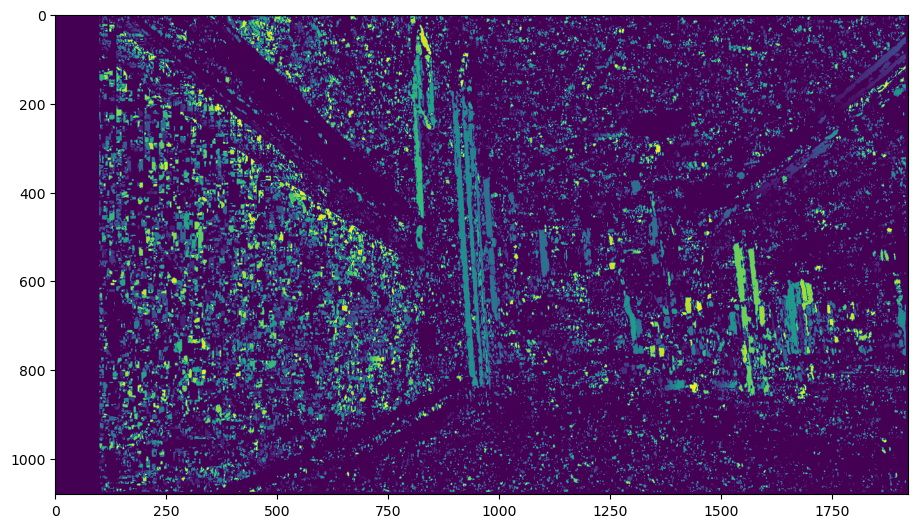

In [5]:
#BM based disparity calculator
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM: 0:00:00.150159


-1.0

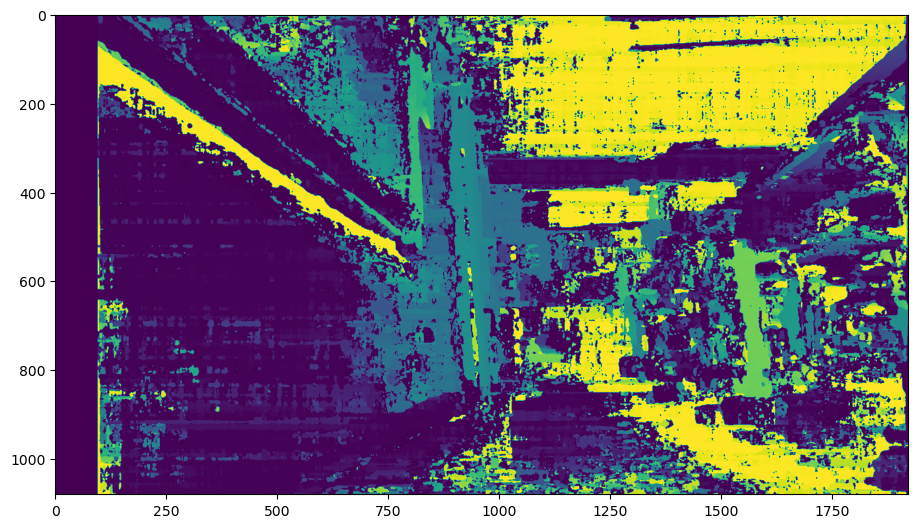

In [6]:
#SGBM based disparity calculator
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);
disp[0,0]

A mor practical decomposer

In [7]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

**Depth Map Calculation**

In [8]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
    
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map


In [9]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

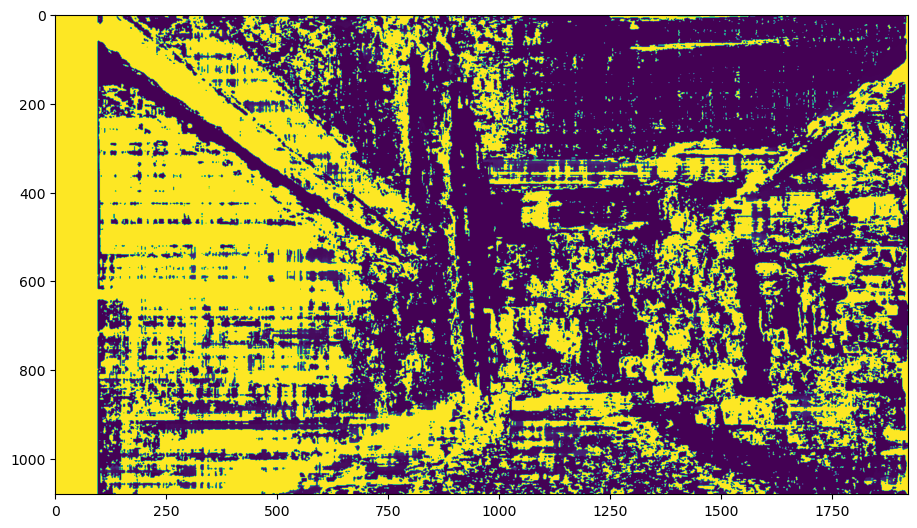

In [10]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

In [11]:
depth.max()

83.93003874934497

Max values derrived from our padding. 

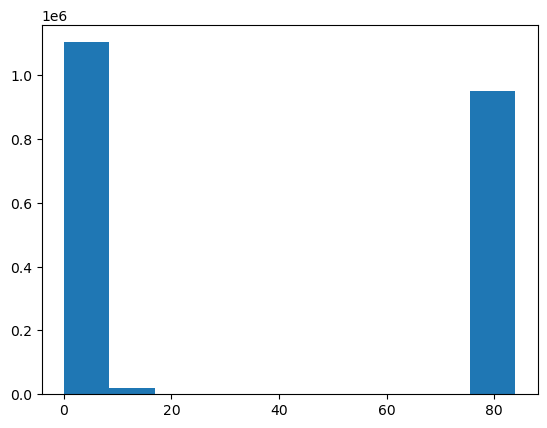

In [12]:
plt.hist(depth.flatten());

We can see that there is a big gap between our real depth values and the erroneous max depth
where the stereo depth computation failed. This means that we can pick a depth of 3000 to
filter out any points that we consider in our feature matching, to make sure that we are
matching features that are within a reasonable distance from us that we have real depth
estimations for.

In [13]:
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break


First non-max value at index 96


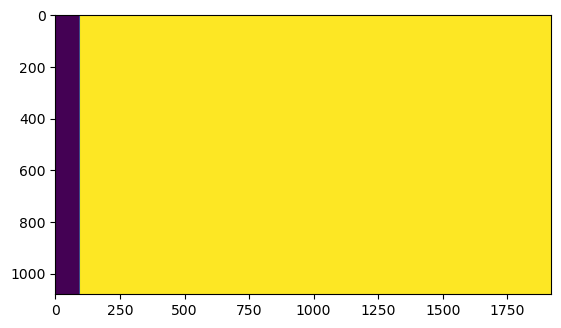

In [14]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);


**Final Function**

In [15]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

Time to compute disparity map using StereoBM: 0:00:00.030983


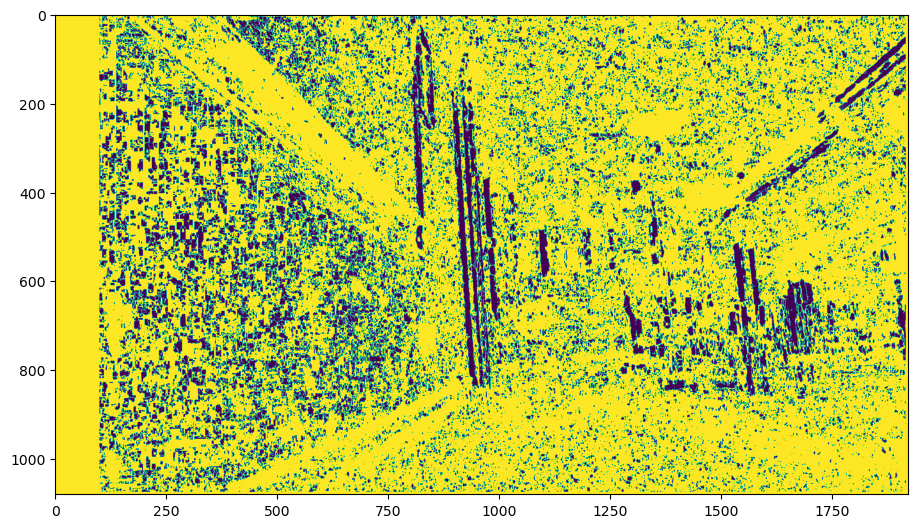

In [16]:
depth = stereo_2_depth(handler.first_image_left,
                       handler.first_image_right,
                       handler.P0,
                       handler.P1, 
                        matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(depth);

# Feature Extraction

In [17]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [18]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches


The creator of SIFT, David Lowe, also proposed a ratio test to determine the level of distinctiveness of features. This test involves finding the two nearest neighbors in the second image to the descriptor of each feature in the first, then using the ratio of their distances from their matched feature to see whether the distance between that feature's descriptor and its closest match is significantly different than the distance to its second closest match. If it is not, then this implies that the feature is not highly distinct, since it is roughly equally similar to at least two features in the second image, and should therefore not be used for photogrammetric reconstruction of motion.

We can see an informative graphic relating the quality of matches according to this metric below:

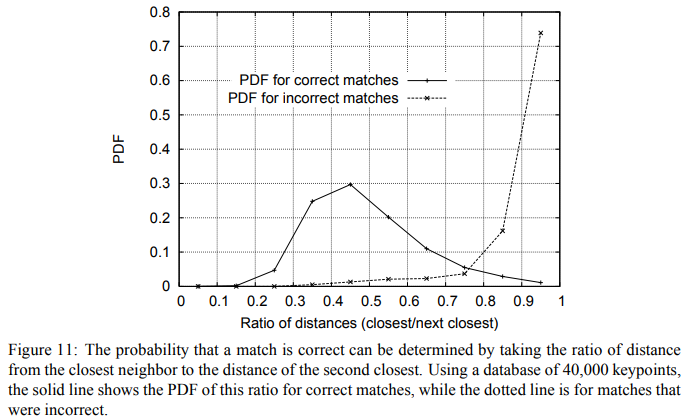

In [19]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [20]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)


Time to compute disparity map using StereoSGBM: 0:00:00.167904
Number of matches before filtering: 471
Number of matches after filtering: 50


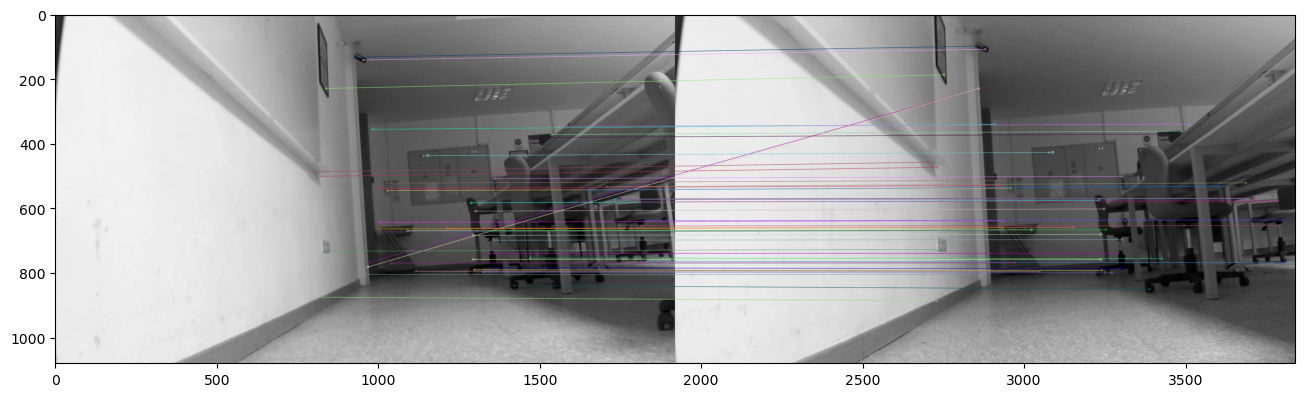

In [21]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoBM: 0:00:00.022486
Number of matches before filtering: 471
Number of matches after filtering: 50


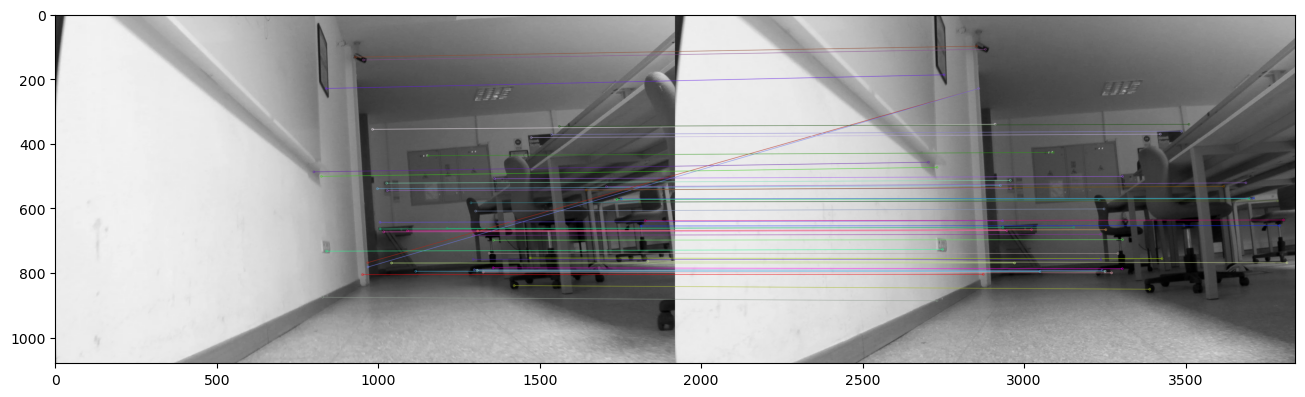

In [22]:
# Now to see the difference with 'bm' matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)


Time to compute disparity map using StereoBM: 0:00:00.040586
Number of matches before filtering: 500
Number of matches after filtering: 166


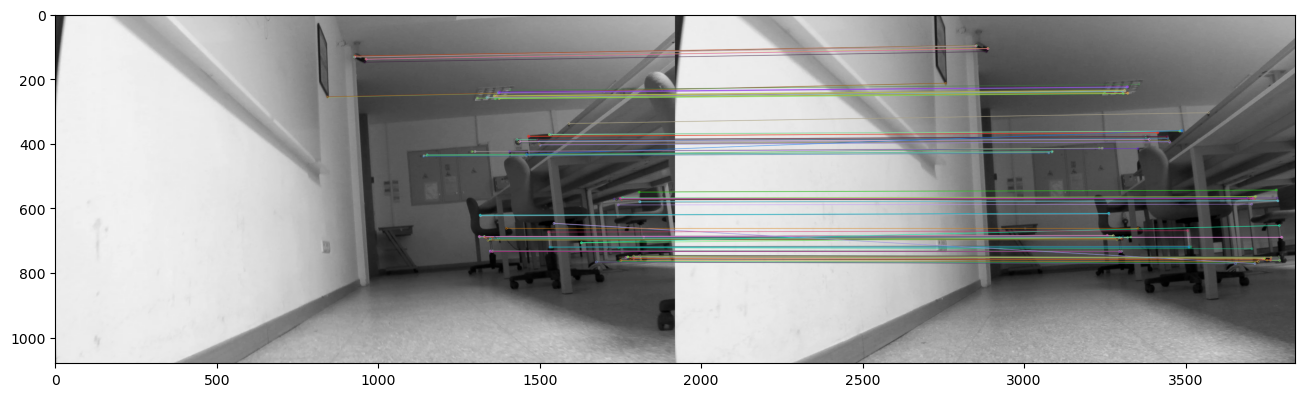

In [23]:
# Now to see the difference with ORB descriptor
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'orb')
kp1, des1 = extract_features(image_plus1, 'orb')
matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.8)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

# MOtion Estimation

In [24]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            #Below is the same but slow version
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

# Visual Odometry

In [25]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
    subset -- (int) number of frames to compute. Defaults to None to compute all frames.
    plot -- (bool) whether to plot the estimated vs ground truth trajectory. Only works if
                   matplotlib is set to tk mode. Default is False.
    
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        # The following code is commented out because it is only necessary if you intend to
        # use very low distance ratios for match filtering. Feel free to uncomment and try
        # out using very low distance ratios, but if you do, comment out the above line.
        # Try to get motion with filter distance, if not increase threshold until success
        #try:
        #    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                           kp0, 
        #                                                           kp1, 
        #                                                           k_left, 
        #                                                           depth)
        
        """except:
            filt_inc = 0.1
            while True:
                print('Not enough features after filter with threshold {},'.format(filter_match_distance),
                      'raising threshold to {} until next frame.'.format(filter_match_distance + filt_inc)) 
                try:
                    matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
                    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
                                                                           kp0, 
                                                                           kp1, 
                                                                           k_left, 
                                                                           depth)
                    break
                except:
                    filt_inc += 0.1
                    continue"""
                  
        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        

        #Please refer to https://docs.opencv.org/4.x/d5/d1f/calib3d_solvePnP.html 
        # The SolvePnPRansac() function computes a pose that relates points in the global
        # coordinate frame to the camera's pose. We used the camera's pose in the first image
        # as the global coordinate frame, reconstruct 3D positions of the features in the
        # image using stereo depth estimation, then find a pose which relates the camera in
        # the next frame to those 3D points. When tracking the vehicle pose over time, what we
        # actually want is to relate the points in the camera's coordinate frame to the global
        # frame, so we want the opposite (inverse) of the transformation matrix provided to us
        # by the SolvePnPRansac function. Recall from the earlier discussion that we can find
        # the inverse of a transformation matrix by making it homogeneous by adding a row of
        # (0, 0, 0, 1) to it, then taking its inverse. Further, we are tracking the vehicle
        # motion from the very first camera pose, so we need the cumulative product of the
        # inverses of each estimated camera pose given to us by SolvePnPRansac. Thus, below
        # we iteratively multiply the T_tot homogeneous transformation matrix that we 
        # instantiated before the for loop by the inverse of each successive pose we estimate,
        # and save its current values into our estimated poses at an index corresponding to our
        # current frame. This way, the transformation matrix at each index will be one that
        # relates 3D homogeneous coordinates in the camera's frame to the global coordinate
        # frame, which is the coordinate frame of the camera's first position. The translation
        # vector component of this transformation matrix will describe where the camera's curent
        # origin is in this global referece frame.
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

#Error Calculator

In [26]:
def calculate_error(ground_truth, estimated, error_type='mse'):
    '''
    Takes arrays of ground truth and estimated poses of shape Nx3x4, and computes error using
    Euclidean distance between true and estimated 3D coordinate at each position.
    
    Arguments:
    ground_truth -- Nx3x4 array of ground truth poses
    estimated -- Nx3x4 array of estimated poses
    
    Optional Arguments:
    error_type -- (str) can be 'mae', 'mse', 'rmse', or 'all' to return dictionary of all 3
    
    Returns:
    error -- either a float or dictionary of error types and float values
    
    '''
    # Find the number of frames in the estimated trajectory to compare with
    nframes_est = estimated.shape[0]
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[:nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[:nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[:nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[:nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[:nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[:nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}


#A sample result>

In [30]:
start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.5, 
                                        detector='sift',
                                        matching='FLANN',
                                        stereo_matcher='sgbm',
                                        mask=mask,     
                                        subset=71)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)


Generating disparities with StereoSGBM
Detecting features with SIFT and matching with FLANN
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.803335
Time to compute frame 2: 0:00:00.890877
Time to compute frame 3: 0:00:00.807620
Time to compute frame 4: 0:00:00.851550
Time to compute frame 5: 0:00:00.868071
Time to compute frame 6: 0:00:00.834990
Time to compute frame 7: 0:00:00.839402
Time to compute frame 8: 0:00:00.839606
Time to compute frame 9: 0:00:00.780576
Time to compute frame 10: 0:00:00.784549
Time to compute frame 11: 0:00:00.818191
Time to compute frame 12: 0:00:00.774203
Time to compute frame 13: 0:00:00.808518
Time to compute frame 14: 0:00:00.757619
Time to compute frame 15: 0:00:00.735782
Time to compute frame 16: 0:00:00.828096
Time to compute frame 17: 0:00:00.750135
Time to compute frame 18: 0:00:00.797843
Time to compute frame 19: 0:00:00.918732
Time to compute frame 20: 0:00:00.880077
Time to compute frame 21: 0:00:00.804801
T

**Plot Trajectory**

AttributeError: 'AxesSubplot' object has no attribute 'set_zlabel'

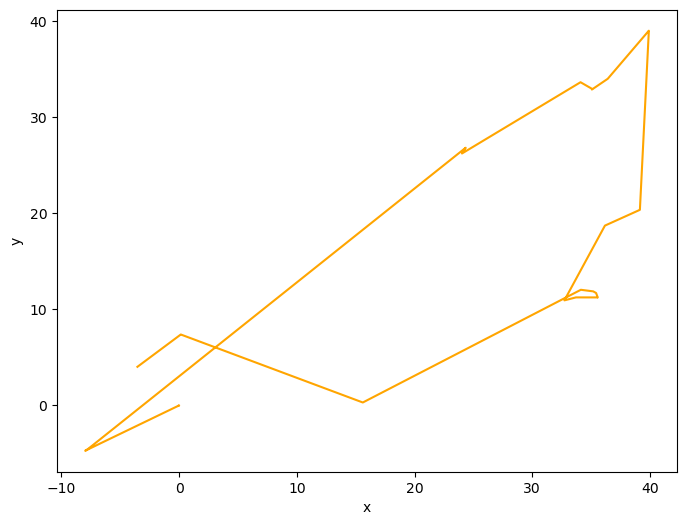

In [35]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)#, projection='3d')

ax.plot(trajectory_nolidar_bm[:, :, 3][:, 0]/5, 
        #trajectory_nolidar_bm[:, :, 3][:, 1], 
        trajectory_nolidar_bm[:, :, 3][:, 2]/5, label='estimated', color='orange')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [ ]:
calculate_error(handler.gt, trajectory_nolidar_bm, 'all')

In [ ]:
import numpy as np
import math

def rotationError(pose_error):
    pose_error = pose_error.flatten()
    a = pose_error[0]
    b = pose_error[4]
    c = pose_error[8]
    d = 0.5 * (a + b + c - 1.0)
    return math.acos(min(max(d, -1.0), 1.0))

def translationError(pose_error):
    pose_error = pose_error.flatten()
    dx = pose_error[3]
    dy = pose_error[7]
    dz = pose_error[11]
    return math.sqrt(dx*dx + dy*dy + dz*dz)

def lastFrameFromSegmentLength(dist, first_frame, leng):
    for i in range(first_frame, len(dist)):
        if dist[i] > dist[first_frame] + leng:
            return i
    return -1

def trajectoryDistances(poses):
    dist = [0]
    for i in range(1, len(poses)):
        P1 = poses[i-1]
        P2 = poses[i]
        dx = P1[0][3] - P2[0][3]
        dy = P1[1][3] - P2[1][3]
        dz = P1[2][3] - P2[2][3]
        dist.append(dist[i-1] + np.sqrt(dx*dx + dy*dy + dz*dz))
    return dist

def calcSequenceErrors(poses_gt, poses_result):
    # error vector
    err = []

    # parameters
    step_size = 1 # every second
    num_lengths = 8
    lengths = np.array([100,200,300,400,500,600,700,800])
    # pre-compute distances (from ground truth as reference)
    dist = trajectoryDistances(poses_gt)

    # for all start positions do
    for first_frame in range(0, poses_result.shape[0], step_size):
        # for all segment lengths do
        for i in range(num_lengths):
            # current length
            leng = lengths[i]

        # compute last frame
        last_frame = lastFrameFromSegmentLength(dist, first_frame, leng)
        # continue, if sequence not long enough
        if last_frame == -1:
            continue


        # convert to homog..
        homo_vec = np.array([0,0,0,1])
        pose_gt_first = np.vstack((poses_gt[first_frame], homo_vec))
        pose_gt_last = np.vstack((poses_gt[last_frame], homo_vec))
        
        poses_result_first = np.vstack((poses_result[first_frame], homo_vec))
        poses_result_last  = np.vstack((poses_result[last_frame], homo_vec))
        
        # compute rotational and translational errors
        pose_delta_gt = np.linalg.inv(pose_gt_first) @ pose_gt_last
        pose_delta_result = np.linalg.inv(poses_result_first) @ poses_result_last
        pose_error = np.linalg.inv(pose_delta_result) @ pose_delta_gt
        r_err = rotationError(pose_error)
        t_err = translationError(pose_error)

        # compute speed
        num_frames = last_frame - first_frame + 1
        speed = leng / (0.1 * num_frames)

        # write to file
        #err.append(errors(first_frame, r_err/leng, t_err/leng, leng, speed))

        # return error vector
    return r_err/leng, 100*t_err/leng

In [ ]:
calcSequenceErrors(handler.gt, trajectory_nolidar_bm)

**Burdan Sonrası ZED için**